# Preparation

## Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import AdamW, get_linear_schedule_with_warmup


from fetchData import fetchdata, cv_events
import __MLP
# from __MLP import getSamplers, convert_df_to_unsqueezed_tensor, train_sequential, clf_report
import random

pd.set_option('display.max_columns', None)

In [6]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data

In [7]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
pheme_bert = pd.read_csv('./data/_PHEME_Bert_simple.csv')
pheme_bert_bracket = pd.read_csv('./data/_PHEME_Bert_brackets.csv')
pheme_thread =  fetchdata('pheme','thread')
pheme_thread_log = pd.read_csv('./data/_PHEME_thread_log.csv')
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')

ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')
ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

ext_thread = fetchdata('ext','thread')
ext_thread_log = pd.read_csv('./data/_PHEMEext_thread_log.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

In [4]:
pheme_event.value_counts()

charliehebdo         2079
sydneysiege          1221
ferguson             1143
ottawashooting        890
germanwings-crash     469
Name: Event, dtype: int64

In [6]:
# pheme_thread = pheme_thread.replace(-np.inf, 0)
# ext_thread = ext_thread.replace(-np.inf, 0)

In [7]:
cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [8]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Sparse-MLP

In [61]:
# import __MLP
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target

scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled,pheme_y,ext_scaled,ext_y)

train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1]) torch.Size([485, 1])


In [62]:
# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse,pheme_y,ext_sparse,ext_y)
# train_dataset = TensorDataset(tensor_x1,tensor_y1)
# test_dataset = TensorDataset(tensor_x2,tensor_y2)
# print(tensor_x1.size(),tensor_x2.size())
# print(tensor_y1.size(),tensor_y2.size())

In [63]:
batch_size = 16
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.1028), std: tensor(1.0864)
torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [88]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(36, 8, bias=True) # 420
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = self.drop_3(self.fc3(x))
        # x = self.fc3(x)
        # x = self.fc3(x)
        return x

In [89]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [90]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.5229, Loss: 0.7027
		Validation) Acc: 0.2577 Loss:0.7938
			Saving the best model w/ val loss 0.7938
			Saving the best model w/ val loss 0.7912
Epoch 2/99	Train) Acc: 0.5390, Loss: 0.6913
		Validation) Acc: 0.2722 Loss:0.7871
			Saving the best model w/ val loss 0.7871
			Saving the best model w/ val loss 0.7838
Epoch 4/99	Train) Acc: 0.5631, Loss: 0.6763
		Validation) Acc: 0.2969 Loss:0.7813
			Saving the best model w/ val loss 0.7813
			Saving the best model w/ val loss 0.7790
Epoch 6/99	Train) Acc: 0.5808, Loss: 0.6690
		Validation) Acc: 0.3175 Loss:0.7765
			Saving the best model w/ val loss 0.7765
			Saving the best model w/ val loss 0.7733
Epoch 8/99	Train) Acc: 0.5903, Loss: 0.6624
		Validation) Acc: 0.3381 Loss:0.7715
			Saving the best model w/ val loss 0.7715
			Saving the best model w/ val loss 0.7697
Epoch 10/99	Train) Acc: 0.5888, Loss: 0.6595
		Validation) Acc: 0.3588 Loss:0.7667
			Saving the best model w/ val loss 0.7667
			Saving the best mode

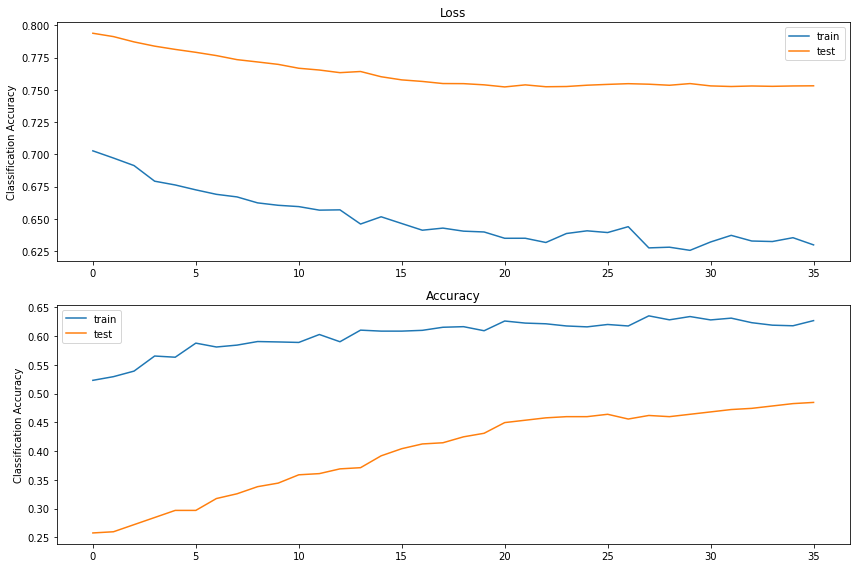

Min of Training Loss: 0.625653
Max of Training Accuracy: 0.634953
Mean of Training Loss: 0.650171
Mean of Training Accuracy: 0.602560
------------
Max of Testing Accuracy: 0.484536
Min of Testing Loss: 0.752214
Mean of Testing Loss: 0.762705
Mean of Testing Accuracy: 0.399370
------------


In [91]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [92]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    val_label_list = []
    # val_preds_list = []
    running_val_preds = []

    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        f1_running = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0
            f1_running += (f1_score(val_label, val_preds,zero_division=True) * val_x.size(0))
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)
            val_label_list.append(val_label)
            running_val_preds.append(val_preds)

    running_val_preds = torch.cat(running_val_preds, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects
    val_loss = val_loss/val_size
    val_acc = val_corrects.double().numpy() / val_size
    f1_running /= val_size
    print("accuracy_score:\t\t%.4f" % val_acc)
    print('Precision Score:\t%.4f' % precision_score(val_label_list,running_val_preds))
    print('Recall Score:\t\t%.4f' % recall_score(val_label_list,running_val_preds))
    print("f1_score:\t\t%.4f" % f1_running)
    print("Test_loss:\t\t%.4f" % val_loss)


In [93]:
import __MLP
model = sparse_model()
PATH = './Model/state_dict_sparse_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model_sparse, criterion, test_dataloader, test_size)

accuracy_score:		0.4845
Precision Score:	0.9281
Recall Score:		0.3496
f1_score:		0.4831
Test_loss:		0.7531


# W2V-MLP

In [112]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_AVGw2v,pheme_y,ext_AVGw2v,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 200]) torch.Size([485, 1, 200])
torch.Size([5802, 1]) torch.Size([485, 1])


In [113]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0187), std: tensor(0.2649)
torch.Size([5802, 1, 200]) torch.Size([485, 1, 200])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [131]:
class W2V_net(nn.Module):
    def __init__(self):
        super(W2V_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 12, bias=True) # 420
        # self.fc2 = nn.Linear(12, 1, bias=True)
        self.fc3 = nn.Linear(12, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.F.elu(self.fc1(x))
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [132]:
model_w2v = W2V_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2v.parameters(), lr=5e-5, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_model.pt"

In [133]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2v, num_epochs=100, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


AttributeError: 'W2V_net' object has no attribute 'F'

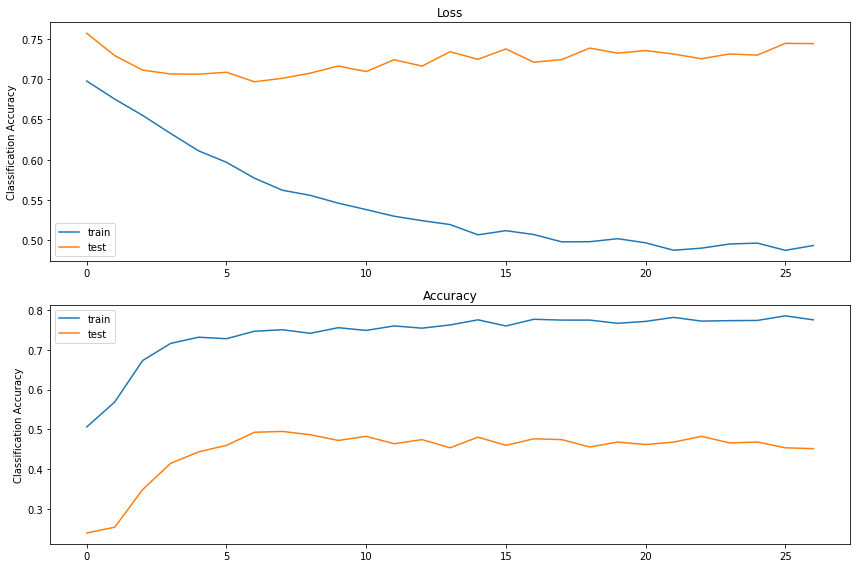

Min of Training Loss: 0.487520
Max of Training Accuracy: 0.785936
Mean of Training Loss: 0.544180
Mean of Training Accuracy: 0.741398
------------
Max of Testing Accuracy: 0.494845
Min of Testing Loss: 0.696725
Mean of Testing Loss: 0.723822
Mean of Testing Accuracy: 0.446124
------------


In [124]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [134]:
model = W2V_net()
PATH = './Model/state_dict_w2v_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

AttributeError: 'W2V_net' object has no attribute 'F'

# BERT - MLP

In [222]:
ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
pheme_bert = pd.read_csv('./data/_PHEME_Bert_simple.csv')

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert, pheme_y, ext_bert, ext_y)
# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert, pheme_y, ext_bert, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
mean: tensor(0.0399), std: tensor(0.3273)
torch.Size([5802, 1, 768])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [223]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [224]:
model_bert = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model.pt"

In [225]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=25, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6158, Loss: 0.6816
		Validation) Acc: 0.6701 Loss:0.6805
			Saving the best model w/ val loss 0.6805
Epoch 2/99	Train) Acc: 0.7351, Loss: 0.5893
		Validation) Acc: 0.3588 Loss:0.7750
Epoch 4/99	Train) Acc: 0.7687, Loss: 0.5149
		Validation) Acc: 0.4000 Loss:0.8158
Epoch 6/99	Train) Acc: 0.7715, Loss: 0.5020
		Validation) Acc: 0.4289 Loss:0.8239
Epoch 8/99	Train) Acc: 0.7678, Loss: 0.4967
		Validation) Acc: 0.4433 Loss:0.7970
Epoch 10/99	Train) Acc: 0.7775, Loss: 0.4780
		Validation) Acc: 0.4247 Loss:0.8405
Epoch 12/99	Train) Acc: 0.7808, Loss: 0.4733
		Validation) Acc: 0.4227 Loss:0.8492
Epoch 14/99	Train) Acc: 0.7823, Loss: 0.4775
		Validation) Acc: 0.4763 Loss:0.8047
Epoch 16/99	Train) Acc: 0.7927, Loss: 0.4620
		Validation) Acc: 0.5526 Loss:0.7237
Epoch 18/99	Train) Acc: 0.8028, Loss: 0.4467
		Validation) Acc: 0.5753 Loss:0.7108
Epoch 20/99	Train) Acc: 0.7978, Loss: 0.4601
		Validation) Acc: 0.5093 Loss:0.7939
Epoch 22/99	Train) Acc: 0.8040, Loss: 0.4387
		V

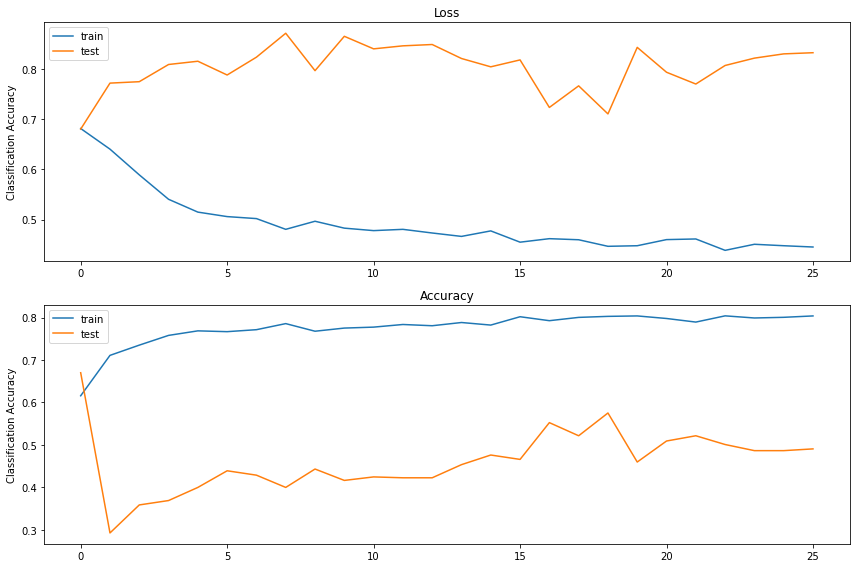

Min of Training Loss: 0.438694
Max of Training Accuracy: 0.804033
Mean of Training Loss: 0.491795
Mean of Training Accuracy: 0.775568
------------
Max of Testing Accuracy: 0.670103
Min of Testing Loss: 0.680462
Mean of Testing Loss: 0.803133
Mean of Testing Accuracy: 0.461142
------------


In [226]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [228]:
model = BERT_net()
PATH = './Model/state_dict_bert_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.6701
Precision Score:	0.8567
Recall Score:		0.6802
f1_score:		0.6261
Test_loss:		0.6805


# Thread

In [131]:
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

scaler = StandardScaler()
pheme_thread_scaled = pd.DataFrame(scaler.fit_transform(pheme_thread_avg))
ext_thread_scaled = pd.DataFrame(scaler.transform(ext_thread_avg))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_thread_scaled,pheme_y,ext_thread_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

In [133]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0123), std: tensor(0.7101)
torch.Size([5802, 1, 38]) torch.Size([485, 1, 38])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [144]:
class thread_model(nn.Module):
    def __init__(self):
        super(thread_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(38, 12, bias=True) # 420
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(12, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        # x = F.elu(self.fc2(x))
        x = self.drop_2(self.fc3(x))
        return x

In [145]:
model_thread = thread_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_thread.parameters(), lr=5e-2, eps=1e-8, weight_decay=1e-4)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_thread_model.pt"

In [146]:
def train1(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("val_preds:\n", val_preds)
                    # print("val_labels:\n", val_label)

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # print("val_corrects:\n", val_corrects)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            # print("val_corrects:\n", val_corrects)

            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list


In [147]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_thread, num_epochs=100, patience=5, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.5627, Loss: 0.7113
		Validation) Acc: 0.3876 Loss:0.7820
		Saving the best model w/ loss 0.7113
Epoch 2/99	Train) Acc: 0.5772, Loss: 0.6900
		Validation) Acc: 0.4701 Loss:0.9844
		Saving the best model w/ loss 0.6900
		Saving the best model w/ loss 0.6881
Epoch 4/99	Train) Acc: 0.5750, Loss: 0.6821
		Validation) Acc: 0.4227 Loss:0.8928
		Saving the best model w/ loss 0.6821
Epoch 6/99	Train) Acc: 0.5777, Loss: 0.7046
		Validation) Acc: 0.7340 Loss:0.6156
		Saving the best model w/ loss 0.6743
Epoch 8/99	Train) Acc: 0.5796, Loss: 0.7102
		Validation) Acc: 0.6619 Loss:0.7641
Epoch 10/99	Train) Acc: 0.5976, Loss: 0.6771
		Validation) Acc: 0.6928 Loss:0.6374
Epoch 12/99	Train) Acc: 0.5722, Loss: 0.6876
		Validation) Acc: 0.6825 Loss:0.6427
Finishing the Model: Loss is not decreasing...
[0.6742614985991658, 0.7102168726740274, 0.6808640064555421, 0.6771220296508318, 0.7037547095320793]


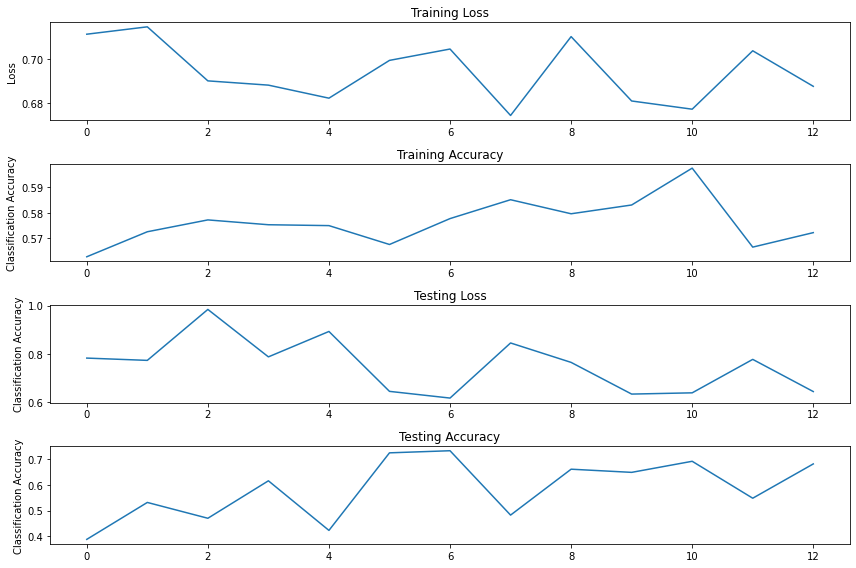

Min of Training Loss: 0.674261
Max of Training Accuracy: 0.597553
Mean of Training Loss: 0.694152
Mean of Training Accuracy: 0.576326
----
Max of Testing Accuracy: 0.734021
Mean of Testing Loss: 0.751980
Mean of Testing Accuracy: 0.585091


In [148]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
model = __MLP.thread_model()
PATH = './Model/state_dict_thread_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

# SPARSE + THREAD

In [239]:
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse, pheme_thread_avg],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse, ext_thread_avg],axis=1))

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 74]) torch.Size([485, 1, 74])
torch.Size([5802, 1]) torch.Size([485, 1])


In [240]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0779), std: tensor(0.8096)
torch.Size([5802, 1, 74]) torch.Size([485, 1, 74])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [262]:
class sparse_thread_net(nn.Module):
    def __init__(self):
        super(sparse_thread_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(74, 12, bias=True)  # 420
        # self.fc2 = nn.Linear(12, 7, bias=True)
        self.fc3 = nn.Linear(12, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        # x = F.elu(self.fc1(x))
        # x = self.drop_3(F.elu(self.fc2(x)))
        # x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x


In [263]:
set_seed(42)
model_sparse_thread = sparse_thread_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_sparse_thread.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 200

PATH = "./Model/state_dict_sparse_thread_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [264]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse_thread, num_epochs=200, patience=30, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/199	Train) Acc: 0.4395, Loss: 0.7489
		Validation) Acc: 0.6866 Loss:0.6424
			Saving the best model w/ val loss 0.6424
			Saving the best model w/ val loss 0.6225
Epoch 2/199	Train) Acc: 0.5467, Loss: 0.6959
		Validation) Acc: 0.7196 Loss:0.6084
			Saving the best model w/ val loss 0.6084
			Saving the best model w/ val loss 0.5996
Epoch 4/199	Train) Acc: 0.6096, Loss: 0.6636
		Validation) Acc: 0.7216 Loss:0.5918
			Saving the best model w/ val loss 0.5918
			Saving the best model w/ val loss 0.5858
Epoch 6/199	Train) Acc: 0.6501, Loss: 0.6378
		Validation) Acc: 0.7381 Loss:0.5849
			Saving the best model w/ val loss 0.5849
Epoch 8/199	Train) Acc: 0.6553, Loss: 0.6272
		Validation) Acc: 0.7320 Loss:0.5904
Epoch 10/199	Train) Acc: 0.6665, Loss: 0.6128
		Validation) Acc: 0.7175 Loss:0.5957
Epoch 12/199	Train) Acc: 0.6848, Loss: 0.6010
		Validation) Acc: 0.6969 Loss:0.6010
Epoch 14/199	Train) Acc: 0.6799, Loss: 0.6036
		Validation) Acc: 0.6845 Loss:0.6129
Epoch 16/199	Train) Acc: 

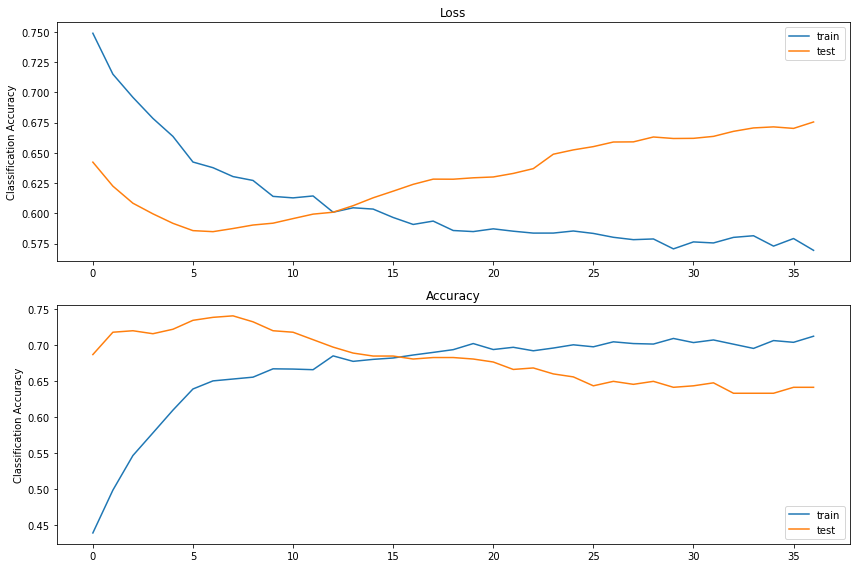

Min of Training Loss: 0.569454
Max of Training Accuracy: 0.711996
Mean of Training Loss: 0.607961
Mean of Training Accuracy: 0.667081
------------
Max of Testing Accuracy: 0.740206
Min of Testing Loss: 0.584901
Mean of Testing Loss: 0.630545
Mean of Testing Accuracy: 0.679911
------------


In [265]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [267]:
model = sparse_thread_net()
PATH = './Model/state_dict_sparse_thread_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.7381
Precision Score:	0.8270
Recall Score:		0.8293
f1_score:		0.7048
Test_loss:		0.5849


# Thread

In [ ]:
model = BERT_net()
PATH = './Model/state_dict_bert_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

In [ ]:
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

scaler = StandardScaler()
pheme_thread_scaled = pd.DataFrame(scaler.fit_transform(pheme_thread_avg))
ext_thread_scaled = pd.DataFrame(scaler.transform(ext_thread_avg))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_thread_scaled,pheme_y,ext_thread_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

In [ ]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

In [ ]:
class thread_model(nn.Module):
    def __init__(self):
        super(thread_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(38, 12, bias=True) # 420
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(12, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        # x = F.elu(self.fc2(x))
        x = self.drop_2(self.fc3(x))
        return x

In [ ]:
model_thread = thread_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_thread.parameters(), lr=5e-2, eps=1e-8, weight_decay=1e-4)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_thread_model.pt"

In [ ]:
def train1(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("val_preds:\n", val_preds)
                    # print("val_labels:\n", val_label)

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # print("val_corrects:\n", val_corrects)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            # print("val_corrects:\n", val_corrects)

            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list


In [ ]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_thread, num_epochs=100, patience=5, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


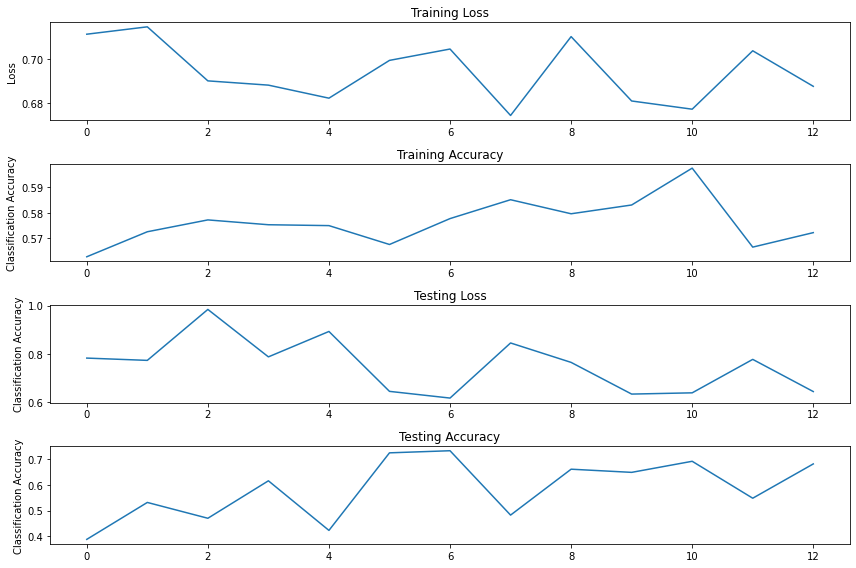

In [ ]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
model = __MLP.thread_model()
PATH = './Model/state_dict_thread_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

# Sparse + W2V -> MLP

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [36]:
pheme_sparse_W2V = pd.concat([pheme_sparse, pheme_AVGw2v],axis=1)
ext_sparse_W2V = pd.concat([ext_sparse, ext_AVGw2v],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_W2V, pheme_y, ext_sparse_W2V, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [59]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(10.0300), std: tensor(133.5756)
torch.Size([5802, 1, 229]) torch.Size([485, 1, 229])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [60]:
class W2V_sparse_net(nn.Module):
    def __init__(self):
        super(W2V_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(229, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [61]:
set_seed(42)
model_w2vsparse = W2V_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2vsparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_sparse_model.pt"

In [63]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2vsparse, num_epochs=40, patience=8, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4964, Loss: 1.1619
		Validation) Acc: 0.4103 Loss:0.8039
		Saving the best model w/ loss 1.1619
		Saving the best model w/ loss 0.8770
Epoch 2/39	Train) Acc: 0.4883, Loss: 0.9466
		Validation) Acc: 0.7443 Loss:0.7230
		Saving the best model w/ loss 0.8220
Epoch 4/39	Train) Acc: 0.4831, Loss: 0.8286
		Validation) Acc: 0.7505 Loss:0.7036
		Saving the best model w/ loss 0.7546
Epoch 6/39	Train) Acc: 0.5019, Loss: 0.8223
		Validation) Acc: 0.7526 Loss:0.7055
Epoch 8/39	Train) Acc: 0.5009, Loss: 0.8449
		Validation) Acc: 0.7526 Loss:0.6902
		Saving the best model w/ loss 0.7223
Epoch 10/39	Train) Acc: 0.5160, Loss: 0.7300
		Validation) Acc: 0.7546 Loss:0.6764
Epoch 12/39	Train) Acc: 0.4995, Loss: 0.7305
		Validation) Acc: 0.7546 Loss:0.6784
		Saving the best model w/ loss 0.7204
Epoch 14/39	Train) Acc: 0.5093, Loss: 0.7425
		Validation) Acc: 0.7546 Loss:0.6702
		Saving the best model w/ loss 0.7117
Epoch 16/39	Train) Acc: 0.5050, Loss: 0.7084
		Validation) Acc: 0.75

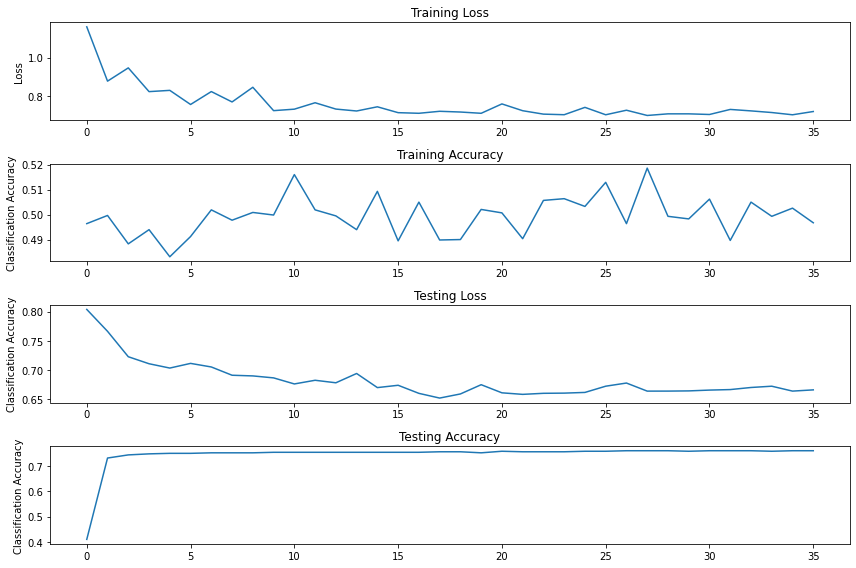

Min of Training Loss: 0.696975
Max of Training Accuracy: 0.518614
Mean of Training Loss: 0.756582
Mean of Training Accuracy: 0.499483
----
Max of Testing Accuracy: 0.760825
Mean of Testing Loss: 0.682468
Mean of Testing Accuracy: 0.745762


In [65]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

In [63]:
pheme_sparse_bert = pd.concat([pheme_sparse, pheme_bert],axis=1)
ext_sparse_bert = pd.concat([ext_sparse, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_bert, pheme_y, ext_sparse_bert, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 804]) torch.Size([485, 1, 804])
torch.Size([5802, 1]) torch.Size([485, 1])


In [70]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(4.2610), std: tensor(100.6901)
torch.Size([5802, 1, 804]) torch.Size([485, 1, 804])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [71]:
class BERT_sparse_net(nn.Module):
    def __init__(self):
        super(BERT_sparse_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(804, 96, bias=True)  # 420
        self.fc2 = nn.Linear(96, 12, bias=True)
        self.fc3 = nn.Linear(12, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [73]:
set_seed(42)
model_bertsparse = BERT_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [74]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bertsparse, num_epochs=40, patience=10, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4941, Loss: 124.3994
		Validation) Acc: 0.5464 Loss:0.7326
			Saving the best model w/ val loss 0.7326
			Saving the best model w/ val loss 0.6381
Epoch 2/39	Train) Acc: 0.4984, Loss: 40.2519
		Validation) Acc: 0.7546 Loss:0.6366
			Saving the best model w/ val loss 0.6366
Epoch 4/39	Train) Acc: 0.4974, Loss: 28.1542
		Validation) Acc: 0.7588 Loss:0.6438
Epoch 6/39	Train) Acc: 0.5214, Loss: 12.6774
		Validation) Acc: 0.7608 Loss:0.6476
Epoch 8/39	Train) Acc: 0.5157, Loss: 6.8757
		Validation) Acc: 0.7629 Loss:0.6488
Epoch 10/39	Train) Acc: 0.5279, Loss: 3.6208
		Validation) Acc: 0.7629 Loss:0.6519
Epoch 12/39	Train) Acc: 0.5143, Loss: 4.1426
		Validation) Acc: 0.7629 Loss:0.6543
Finishing the Model: Val Loss is not decreasing...
[12.247996624134114, 6.875695409999967, 6.122549759318441, 3.620785112362079, 4.001251366786898]


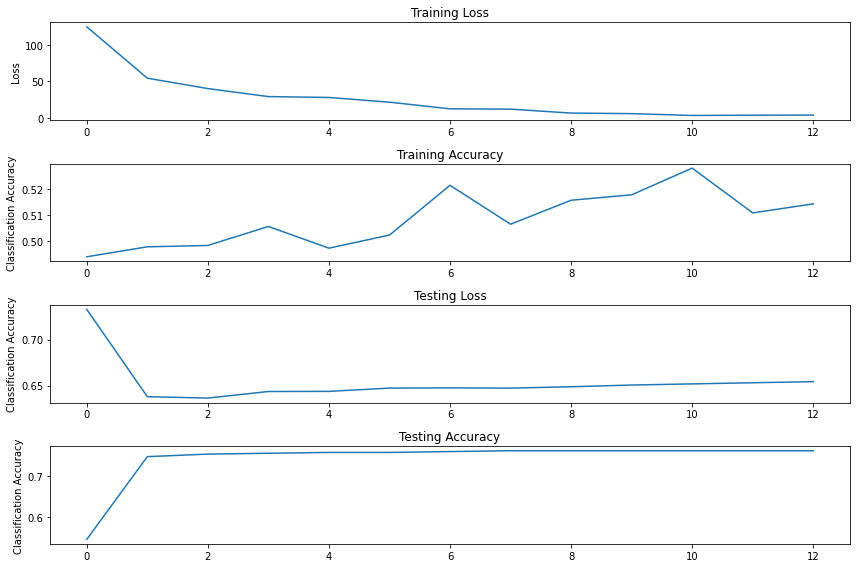

Min of Training Loss: 3.620785
Max of Training Accuracy: 0.527921
Mean of Training Loss: 26.768456
Mean of Training Accuracy: 0.508498
----
Max of Testing Accuracy: 0.762887
Mean of Testing Loss: 0.653529
Mean of Testing Accuracy: 0.743220


In [75]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP (Multi)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread.values],axis=1))
pheme_sparse_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

ext_sparse_scaled = pd.DataFrame(scaler.transform(ext_sparse))
# Test = np.concatenate([test, ext_bert.values],axis=1)

In [11]:
# tensor_x11 = torch.Tensor(pheme_scaled).unsqueeze(1)
tensor_x11 = torch.Tensor(pheme_sparse_scaled.values).unsqueeze(1)
tensor_x12 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)

tensor_x21 = torch.Tensor(ext_sparse_scaled.values).unsqueeze(1)
# tensor_x21 = torch.Tensor(ext_sparse_scaled).unsqueeze(1)
tensor_x22 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)


In [83]:
# tensor_x11, tensor_x12, tensor_y1, tensor_x21, tensor_x22, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse, pheme_y, ext_sparse, ext_y, pheme_bert, ext_bert)
# train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)
# test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)

In [12]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x21)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x11.shape,tensor_x21.shape)
print(tensor_x12.shape,tensor_x22.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0314), std: tensor(0.9928)
torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [13]:
class BERT_sparse_net_multi(nn.Module):
    def __init__(self):
        super(BERT_sparse_net_multi, self).__init__()  # 1*20

        self.layer1 = nn.Sequential(
            nn.Linear(36, 5, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(5, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [14]:
# _MLP.set_seed(42)
model_bertsparse_multi = BERT_sparse_net_multi()
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [15]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_sparse, val_embedding, val_labels = val
            val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
            val_outputs = model(val_sparse, val_embedding)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_labels)
            v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_loss += (v_loss.item() * val_labels.size(0))
            val_corrects += torch.sum(val_preds == val_labels)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/val_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/val_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train3(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sparse, embedding, labels = data
            sparse, embedding, labels = sparse.float(), embedding.float(), labels.float().squeeze(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sparse, embedding)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * sparse.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_sparse, val_embedding, val_labels = data
                    val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
                    val_outputs = model(val_sparse, val_embedding)
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs size:",val_outputs.size())
                    # print("val_label size:",val_label.size())
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("pred size:",val_preds.size())

                    # print("Length of val_preds:",val_preds.size())
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_labels)
                    v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                    val_loss += (v_loss.item() * val_labels.size(0))
                    val_corrects += torch.sum(val_preds == val_labels)
                    # print("== length",val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                    # print("val_corrects:",val_corrects)
                # print("length of one batch")
                # print("FINAL val_corrects:",val_corrects)
                # print("test_size:",test_size)
                    
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

In [16]:
train_acc, train_loss, val_acc, val_loss_list = train3(patience=8,model=model_bertsparse_multi, num_epochs=epochs, criterion=criterion, optimizer=optimizer,scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.4941, Loss: 0.6926
		Validation) Acc: 0.2557 Loss:0.4489
		Saving the best model w/ loss 0.6926
		Saving the best model w/ loss 0.6845
Epoch 2/39	Train) Acc: 0.6832, Loss: 0.6710
		Validation) Acc: 0.5113 Loss:0.4196
		Saving the best model w/ loss 0.6710
		Saving the best model w/ loss 0.6479
Epoch 4/39	Train) Acc: 0.7275, Loss: 0.6219
		Validation) Acc: 0.5113 Loss:0.3692
		Saving the best model w/ loss 0.6219
		Saving the best model w/ loss 0.5959
Epoch 6/39	Train) Acc: 0.7468, Loss: 0.5738
		Validation) Acc: 0.3196 Loss:0.5204
		Saving the best model w/ loss 0.5738
		Saving the best model w/ loss 0.5562
Epoch 8/39	Train) Acc: 0.7434, Loss: 0.5476
		Validation) Acc: 0.5113 Loss:0.2878
		Saving the best model w/ loss 0.5476
		Saving the best model w/ loss 0.5309
Epoch 10/39	Train) Acc: 0.7558, Loss: 0.5322
		Validation) Acc: 0.5113 Loss:0.3495
		Saving the best model w/ loss 0.5191
Epoch 12/39	Train) Acc: 0.7659, Loss: 0.5155
		Validation) Acc: 0.5113 Loss:0.

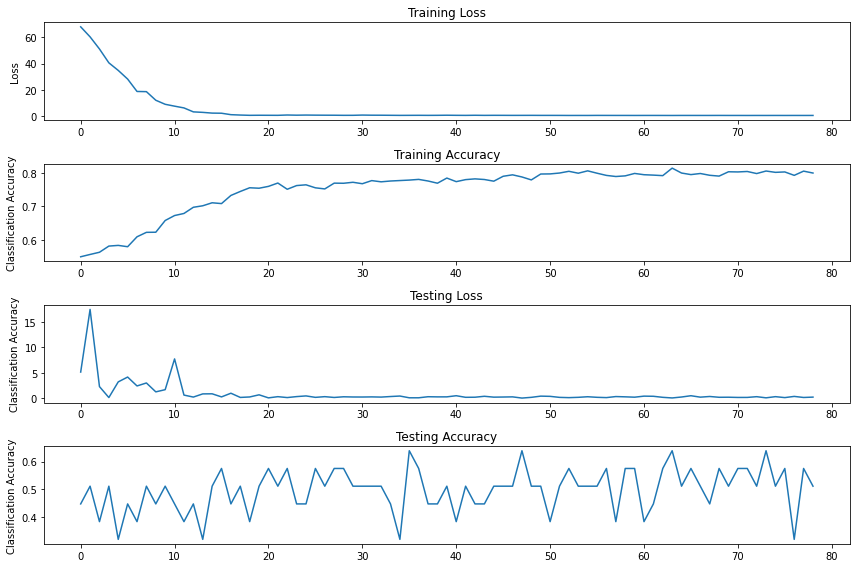

Min of Training Loss: 0.439555
Max of Training Accuracy: 0.814030
Mean of Training Loss: 5.060540
Mean of Training Accuracy: 0.752606
----
Max of Testing Accuracy: 0.639175
Min of Testing Loss: 0.084118
Mean of Testing Loss: 0.906964
Mean of Testing Accuracy: 0.497586


In [49]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [300]:
predict(model_bertsparse, criterion, test_dataloader, test_size)

ValueError: too many values to unpack (expected 2)

## Previous Models

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 8, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(10, 1)  # 420
)

Min of Training Loss: 0.471854
Max of Training Accuracy: 0.785764
Mean of Training Loss: 0.505716
Mean of Training Accuracy: 0.758512
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.351359
Mean of Testing Accuracy: 0.454525

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 5, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(7, 1)  # 420
)

Min of Training Loss: 0.467921
Max of Training Accuracy: 0.788694
Mean of Training Loss: 0.501997
Mean of Training Accuracy: 0.760402
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.348198
Mean of Testing Accuracy: 0.459259

# BERT + THREAD (Multi)

In [79]:
# BERT + SPARSE + THREAD (Multi)

scaler = StandardScaler()

# pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread_avg.values],axis=1))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

# ext_sparse_scaled = scaler.transform(np.concatenate([ext_sparse.values, ext_thread_avg.values],axis=1))
# Test = np.concatenate([test, ext_bert.values],axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.concat([pheme_sparse, pheme_thread], axis=1)
X_test = pd.concat([ext_sparse, ext_thread], axis=1)

# X_train = scaler.fit_transform(X_train.values)
X_train = np.concatenate([X_train, pheme_bert.values], axis=1)

# X_test = scaler.fit_transform(X_test.values)
X_test = np.concatenate([X_test, ext_bert.values],axis=1)

# Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

array([[-0.07906651,  0.15336594, -0.92330599, ...,  0.01090725,
         0.39039801,  0.89328313],
       [-0.07906651, -1.15520636, -0.92330599, ..., -4.06366165,
        -1.13204193, -1.11946589],
       [-0.07906651, -1.15520636, -0.92330599, ...,  0.10918358,
         0.25456694, -1.11946589],
       ...,
       [-0.07906651,  0.15336594, -0.92330599, ...,  0.15300712,
        -1.84091033, -1.11946589],
       [-0.07906651,  0.15336594, -0.92330599, ..., -4.06366165,
         1.33414098,  0.89328313],
       [-0.07906651, -1.15520636, -0.92330599, ..., -0.10647179,
         0.37766385, -1.11946589]])

In [31]:
pheme_temp = pd.concat([pheme_bert, pheme_thread_avg], axis=1)
ext_temp = pd.concat([ext_bert, ext_thread_avg], axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_y2)

batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(245.7166), std: tensor(7631.2808)
torch.Size([5802, 1, 806]) torch.Size([485, 1, 806])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [33]:
# pheme_temp = pd.concat([pheme_sparse, pheme_thread_log], axis=1)
# ext_temp = pd.concat([ext_sparse, ext_thread_log], axis=1)

tensor_x1 = torch.Tensor(pheme_thread_avg.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)

tensor_x2 = torch.Tensor(ext_thread_avg.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)

tensor_x1_2= torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_x2_2 = torch.Tensor(ext_bert.values).unsqueeze(1)

train_dataset = TensorDataset(tensor_x1, tensor_x1_2, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_x2_2, tensor_y2)


In [39]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_x1_2.shape,tensor_x2_2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(6030.6250), std: tensor(75728.3438)
torch.Size([5802, 1, 38]) torch.Size([485, 1, 38])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [40]:
class sparse_thread_net_multi(nn.Module):
    def __init__(self):
        super(sparse_thread_net_multi, self).__init__()  # 1*20


        self.layer1 = nn.Sequential(
            nn.Linear(38, 8, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x


In [43]:
set_seed()
model_sparsethread_multi = sparse_thread_net_multi()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_sparsethread_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []


epochs = 200

PATH = "./Model/state_dict_sparse_thread_model_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)


In [46]:
train_acc, train_loss, val_acc, val_loss_list = train3(model=model_sparsethread_multi, num_epochs=epochs,patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/199	Train) Acc: 0.5495, Loss: 68.0819
		Validation) Acc: 0.4474 Loss:5.1839
Epoch 2/199	Train) Acc: 0.5629, Loss: 51.1780
		Validation) Acc: 0.3835 Loss:2.3340
Epoch 4/199	Train) Acc: 0.5834, Loss: 34.8244
		Validation) Acc: 0.3196 Loss:3.2573
Epoch 6/199	Train) Acc: 0.6091, Loss: 18.7582
		Validation) Acc: 0.3835 Loss:2.4596
Epoch 8/199	Train) Acc: 0.6227, Loss: 12.0562
		Validation) Acc: 0.4474 Loss:1.3011
		Saving the best model w/ loss 8.9675
Epoch 10/199	Train) Acc: 0.6725, Loss: 7.5433
		Validation) Acc: 0.4474 Loss:7.7603
		Saving the best model w/ loss 7.5433
		Saving the best model w/ loss 6.1989
Epoch 12/199	Train) Acc: 0.6972, Loss: 3.1838
		Validation) Acc: 0.4474 Loss:0.2800
		Saving the best model w/ loss 3.1838
		Saving the best model w/ loss 2.8038
Epoch 14/199	Train) Acc: 0.7106, Loss: 2.2419
		Validation) Acc: 0.5113 Loss:0.9200
		Saving the best model w/ loss 2.2419
		Saving the best model w/ loss 2.1490
Epoch 16/199	Train) Acc: 0.7325, Loss: 1.0469
		Validat

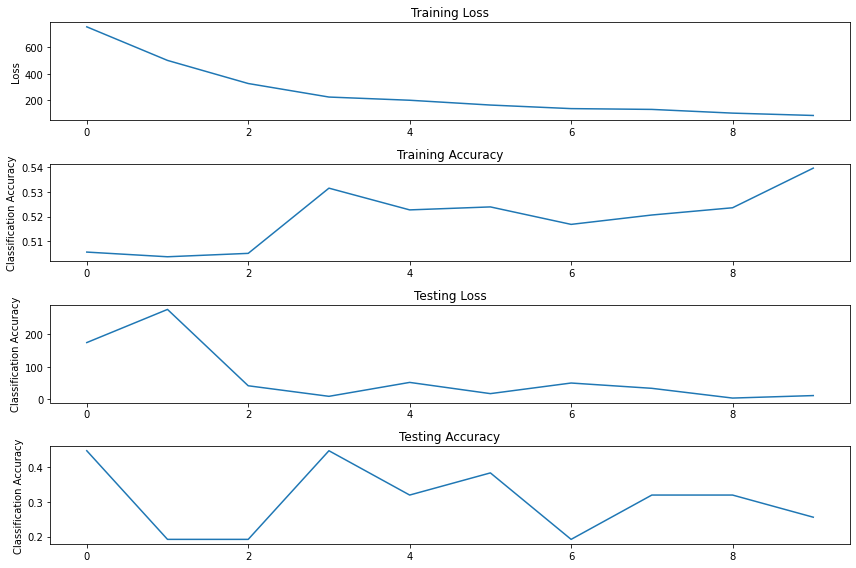

Min of Training Loss: 84.952446
Max of Training Accuracy: 0.539642
Mean of Training Loss: 262.715087
Mean of Training Accuracy: 0.519373
----
Max of Testing Accuracy: 0.447423
Min of Testing Loss: 4.358668
Mean of Testing Loss: 67.619078
Mean of Testing Accuracy: 0.306804


In [45]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# BERT + SPARSE + THREAD

In [268]:
def convert_df_to_unsqueezed_tensor(trainX, trainY, testX, testY, TrainX2=None, TestX2=None):
    tensor_x1 = torch.Tensor(trainX).unsqueeze(1)
    tensor_y1 = torch.Tensor(trainY.values).unsqueeze(1)

    tensor_x2 = torch.Tensor(testX).unsqueeze(1)
    tensor_y2 = torch.Tensor(testY).unsqueeze(1)
    if ((TrainX2 is None) | (TestX2 is None)):
        
        return tensor_x1, tensor_y1, tensor_x2, tensor_y2
    elif (TrainX2 is not None & TestX2 is not None):
        tensor_x1_2= torch.Tensor(TrainX2.values).unsqueeze(1)
        tensor_x2_2 = torch.Tensor(TestX2.values).unsqueeze(1)
        return tensor_x1, tensor_x1_2, tensor_y1, tensor_x2, tensor_x2_2, tensor_y2

In [278]:
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')
pheme_bert = pd.read_csv('./data/_PHEME_Bert_simple.csv')
ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')

# pheme_bert = pd.read_csv('./data/_PHEME_Bert_brackets.csv')
# ext_bert = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse, pheme_thread_avg],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse, ext_thread_avg],axis=1))

pheme_temp = np.concatenate([pheme_bert, pheme_temp],axis=1)
ext_temp = np.concatenate([ext_bert, ext_temp],axis=1)

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 842]) torch.Size([485, 1, 842])
torch.Size([5802, 1]) torch.Size([485, 1])


In [279]:
# # Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# # Test = pd.concat([ext_bert, ext_sparse], axis=1)

# tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
# tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
# train_dataset = TensorDataset(tensor_x1,tensor_y1)

# tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
# tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
# test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [280]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0310), std: tensor(0.4013)
torch.Size([5802, 1, 842]) torch.Size([485, 1, 842])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [341]:
class BERT_sparse_thread_net1(nn.Module):
    def __init__(self):
        super(BERT_sparse_thread_net1, self).__init__()  # 1*20
        self.fc1 = nn.Linear(842, 12, bias=True)  # 420
        # self.fc2 = nn.Linear(30, 12, bias=True)
        self.fc3 = nn.Linear(12, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(842)

    def forward(self, x):
        # x = F.elu(self.fc1(x))
        x = self.drop_3(F.elu(self.fc1(x)))
        # x = self.drop_2(F.elu(self.fc2(x)))
        # x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x


In [342]:
set_seed(42)
model_bertsparse = BERT_sparse_thread_net1()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 200

PATH = "./Model/state_dict_bert_thread_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [343]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bertsparse, num_epochs=200, patience=30, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/199	Train) Acc: 0.5889, Loss: 0.6778
		Validation) Acc: 0.6247 Loss:0.6723
			Saving the best model w/ val loss 0.6723
			Saving the best model w/ val loss 0.6703
Epoch 2/199	Train) Acc: 0.7172, Loss: 0.6056
		Validation) Acc: 0.5526 Loss:0.6923
Epoch 4/199	Train) Acc: 0.7515, Loss: 0.5607
		Validation) Acc: 0.5732 Loss:0.6846
Epoch 6/199	Train) Acc: 0.7575, Loss: 0.5371
		Validation) Acc: 0.5814 Loss:0.6837
Epoch 8/199	Train) Acc: 0.7520, Loss: 0.5332
		Validation) Acc: 0.5732 Loss:0.6945
Epoch 10/199	Train) Acc: 0.7666, Loss: 0.5103
		Validation) Acc: 0.5938 Loss:0.6858
Epoch 12/199	Train) Acc: 0.7765, Loss: 0.5029
		Validation) Acc: 0.5979 Loss:0.6795
Epoch 14/199	Train) Acc: 0.7804, Loss: 0.5060
		Validation) Acc: 0.5608 Loss:0.7261
Epoch 16/199	Train) Acc: 0.7837, Loss: 0.4908
		Validation) Acc: 0.5649 Loss:0.7342
Epoch 18/199	Train) Acc: 0.7904, Loss: 0.4818
		Validation) Acc: 0.5402 Loss:0.7531
Epoch 20/199	Train) Acc: 0.7868, Loss: 0.4871
		Validation) Acc: 0.6082 Loss:

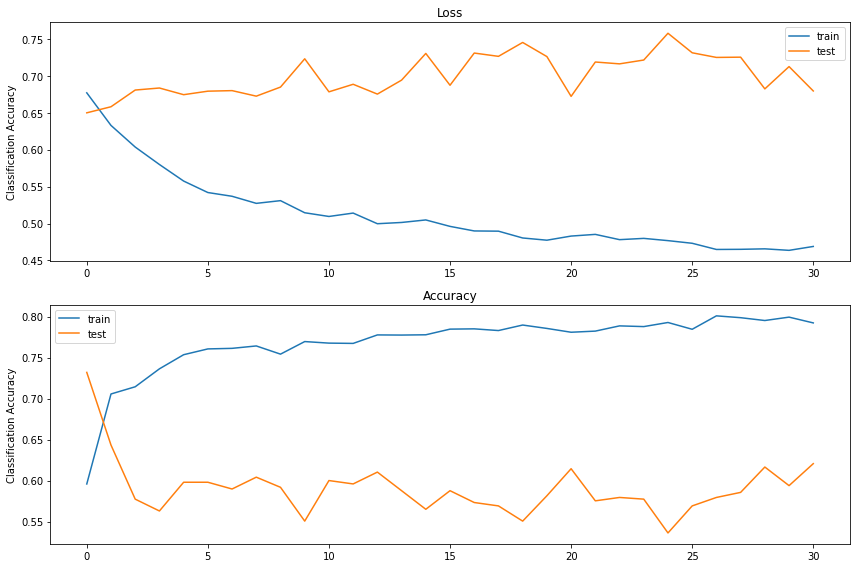

Min of Training Loss: 0.463665
Max of Training Accuracy: 0.800931
Mean of Training Loss: 0.511931
Mean of Training Accuracy: 0.768239
------------
Max of Testing Accuracy: 0.731959
Min of Testing Loss: 0.649860
Mean of Testing Loss: 0.700287
Mean of Testing Accuracy: 0.590821
------------


In [337]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [344]:
model = BERT_sparse_thread_net1()
PATH = './Model/state_dict_bert_thread_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.6021
Precision Score:	0.8929
Recall Score:		0.5420
f1_score:		0.5506
Test_loss:		0.6703


# BERT + SPARSE + THREAD (Multi)

In [6]:
# pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread.values],axis=1))
# # Train = np.concatenate([train, pheme_bert.values],axis=1)

# ext_sparse_scaled = scaler.fit_transform(np.concatenate([ext_sparse.values, ext_thread.values],axis=1))
# # Test = np.concatenate([test, ext_bert.values],axis=1)

NameError: name 'scaler' is not defined

In [70]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# X_train = pd.concat([pheme_sparse, pheme_thread], axis=1)
# X_test = pd.concat([ext_sparse, ext_thread], axis=1)

# # X_train = scaler.fit_transform(X_train.values)
# X_train = np.concatenate([X_train, pheme_bert.values], axis=1)

# # X_test = scaler.fit_transform(X_test.values)
# X_test = np.concatenate([X_test, ext_bert.values],axis=1)

# # Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# # Test = pd.concat([ext_bert, ext_sparse], axis=1)

# tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
# tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
# train_dataset = TensorDataset(tensor_x1,tensor_y1)

# tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
# tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
# test_dataset = TensorDataset(tensor_x2,tensor_y2)

___

In [17]:
pheme_temp = pd.concat([pheme_sparse, pheme_thread_log], axis=1)
ext_temp = pd.concat([ext_sparse, ext_thread_log], axis=1)

tensor_x1 = torch.Tensor(pheme_temp.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)

tensor_x2 = torch.Tensor(ext_temp.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)

tensor_x1_2= torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_x2_2 = torch.Tensor(ext_bert.values).unsqueeze(1)

train_dataset = TensorDataset(tensor_x1, tensor_x1_2, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_x2_2, tensor_y2)


In [20]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_x1_2.shape,tensor_x2_2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(33.2568), std: tensor(234.3891)
torch.Size([5802, 1, 65]) torch.Size([485, 1, 65])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [23]:
class BERT_sparse_thread_net_multi(nn.Module):
    def __init__(self):
        super(BERT_sparse_thread_net_multi, self).__init__()  # 1*20


        self.layer1 = nn.Sequential(
            nn.Linear(65, 12, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(12, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [25]:
set_seed()
model_bertsparsethread_2 = BERT_sparse_thread_net_multi()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparsethread_2.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []


epochs = 60

PATH = "./Model/state_dict_bert_sparse_thread_model_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [32]:
train_acc, train_loss, val_acc, val_loss_list = train3(model=model_bertsparsethread_2, num_epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.5355, Loss: 1.4659
		Validation) Acc: 0.3196 Loss:0.5631
		Saving the best model w/ loss 1.4659
		Saving the best model w/ loss 1.0069
Epoch 2/39	Train) Acc: 0.6227, Loss: 0.8238
		Validation) Acc: 0.3835 Loss:0.3571
		Saving the best model w/ loss 0.8238
		Saving the best model w/ loss 0.7022
Epoch 4/39	Train) Acc: 0.6736, Loss: 0.6510
		Validation) Acc: 0.6392 Loss:0.1791
		Saving the best model w/ loss 0.6510
		Saving the best model w/ loss 0.5995
Epoch 6/39	Train) Acc: 0.7191, Loss: 0.5723
		Validation) Acc: 0.2557 Loss:0.6381
		Saving the best model w/ loss 0.5723
		Saving the best model w/ loss 0.5571
Epoch 8/39	Train) Acc: 0.7297, Loss: 0.5504
		Validation) Acc: 0.4474 Loss:0.3510
		Saving the best model w/ loss 0.5504
		Saving the best model w/ loss 0.5264
Epoch 10/39	Train) Acc: 0.7451, Loss: 0.5356
		Validation) Acc: 0.5113 Loss:0.3160
		Saving the best model w/ loss 0.5221
Epoch 12/39	Train) Acc: 0.7535, Loss: 0.5185
		Validation) Acc: 0.5113 Loss:0.

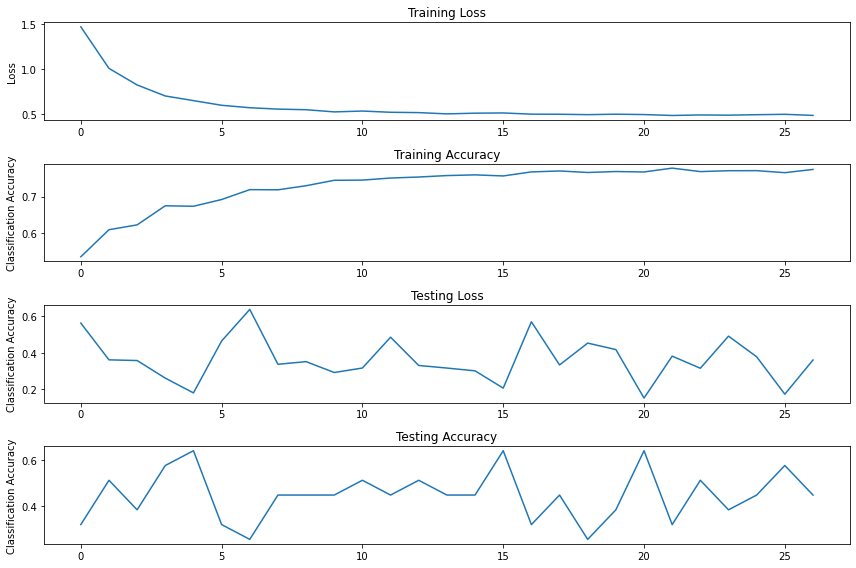

Min of Training Loss: 0.486871
Max of Training Accuracy: 0.777835
Mean of Training Loss: 0.592985
Mean of Training Accuracy: 0.729991
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.362035
Mean of Testing Accuracy: 0.447423


In [34]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# TESTING

In [ ]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
pheme_bert = pd.read_csv('./data/_PHEME_Bert_simple.csv')
pheme_bert_bracket = pd.read_csv('./data/_PHEME_Bert_brackets.csv')
pheme_thread =  fetchdata('pheme','thread')
pheme_thread_log = pd.read_csv('./data/_PHEME_thread_log.csv')
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')


ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')
ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

ext_thread = fetchdata('ext','thread')
ext_thread_log = pd.read_csv('./data/_PHEMEext_thread_log.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

In [18]:
model_paths = ["./Model/state_dict_sparse_model.pt",
               "./Model/state_dict_w2v_model.pt",
               "./Model/state_dict_bert_model.pt",
               "./Model/state_dict_thread_model.pt",
               "./Model/state_dict_w2v_sparse_model.pt", 
               "./Model/state_dict_bert_sparse_model.pt",
               "./Model/state_dict_bert_sparse_multi.pt",
               "./Model/state_dict_sparse_thread_model_multi.pt",
                "./Model/state_dict_bert_sparse_model.pt",
                "./Model/state_dict_bert_thread_model.pt",
                "./Model/state_dict_bert_sparse_thread_model_multi.pt"
               ]


# Sparse

In [34]:
#pheme_sparse -> pheme_scaled -> tensor
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled,pheme_y,ext_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size, test_size = int(tensor_y1.size(0)), int(tensor_y2.size(0))

print("Training: ",tensor_x1.shape,"/", tensor_x2.shape)
print("Testing2: ",tensor_y1.shape,"/", tensor_y2.shape)
print("Train Size",train_size,"/ Test Size",test_size)
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'


Training:  torch.Size([5802, 1, 36]) / torch.Size([485, 1, 36])
Testing2:  torch.Size([5802, 1]) / torch.Size([485, 1])
Train Size 5802 / Test Size 485


In [ ]:
# bert_classifier.load_state_dict(torch.load(PATH))
# testing_process(bert_classifier, X_val, y_val)
predict(model, criterion, val_dataloader, val_size)

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'bert_predict' is not defined

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/test_size
    val_acc = val_corrects.double() / val_size

    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    
    print(classification_report(y_test, result))

    return val_acc, val_loss, val_corrects, val_preds_list, val_label_list